###$\color{blue}{\text{3.0. Environmental Set-up & Data Loading}}$

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Google Drive where you have saved the unzipped
FOLDERNAME =  'ADX/'

assert FOLDERNAME is not None, 'ERROR'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
import pandas as pd
import numpy as np

# Part 1.1에서 전처리하여 저장한 데이터 Import
df = pd.read_pickle('./ADX/Data_RealEstate/dataset_preprocessing_team1real_v2.pickle')
y_price = df.loc[:, '거래금액(만원)_adj']
df_ = df.drop('거래금액(만원)_adj', 1)

# 추후에 Implementation for Real-World Practice에 사용할 Test Data

#우리가 testset을 가지고 있기 않기 때문에 에러발생 -> 주석처리
#df_test = pd.read_csv('./ADX/Data_RealEstate/testset.csv', encoding ='cp949')

<ipython-input-2-f1308930ba9d>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_ = df.drop('거래금액(만원)_adj', 1)


In [ ]:
# 한글 나눔포트 사용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

###$\color{blue}{\text{3.1. Data split & Normalization}}$

모델을 튜닝하기 위한 validation set 설정

In [ ]:
def splitData(df, ratio, y_column):
    
    columns_ = df.columns
    # Subsample the data
    mask = list(range(0,df.shape[0], ratio))
    X_val = df.iloc[mask, :].drop(y_column, 1)
    y_val = df.iloc[mask][y_column]
    
    mask = ~df.index.isin(mask)
    X_train = df.loc[mask, :].drop(y_column, 1)
    y_train = df.loc[mask, y_column]
    
    return X_train, y_train, X_val, y_val

# train set, validation set split 
# train set, validation set = 4 : 1

X_train, y_train, X_val, y_val = splitData(df_, 5, y_column = '평당가격') 


#################################################################################
# TODO: 연속형 변수에 대해서 Z normalize를 설계 및 적용                         #
# 대표적으로 Z normalize와 min max normalize가 존재 
# 이번에는 Z-normalize를 사용!!
#
# 1. training dataset에 normalize하는 함수 생성(validation/ test에 사용할 cache 
# 저장)
# 2. validation set과 test set을 normalize하는 함수 생성 및 적용
#################################################################################

##1. 
def z_normalize(data, column):
    temp_df = data[column]
    normalized_df = (temp_df - temp_df.mean()) / temp_df.std()
    cache = {}
    cache['mean'] = temp_df.mean()
    cache['std'] = temp_df.std()
    return normalized_df, cache

    
##2. 
def z_normalize_val(data, column, cache):
    temp_df = data[column]
    normalized_df = (temp_df - cache['mean']) / cache['std']
    return normalized_df

<ipython-input-4-9c5607a99a78>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_val = df.iloc[mask, :].drop(y_column, 1)
<ipython-input-4-9c5607a99a78>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = df.loc[mask, :].drop(y_column, 1)


In [ ]:
# 위 block에서 만들어진 z_normalize와 z_normalize_val 적용 (Error 날 경우 다시 고민할 것)
X_train_norm = X_train.copy()
X_train_norm.loc[:, ['전용/연면적(㎡)','층','건물년식']], cache = z_normalize(X_train, ['전용/연면적(㎡)','층','건물년식'])
X_val_norm = X_val.copy()
X_val_norm.loc[:, ['전용/연면적(㎡)','층','건물년식']] = z_normalize_val(X_val, ['전용/연면적(㎡)','층','건물년식'], cache)

###$\color{blue}{\text{3.2. Random Forest}}$

랜덤포레스트 (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

**Hyperparameter Optimization (Tuning)**. 랜덤포레스트에서 hyperparameter들은 n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf 등등이 존재한다. 이러한 하이퍼파라미터는 모델 성능에 큰 영향을 미치므로 training data와 validation data를 활용하여서 좋은 성능의 모델을 출력

**Approximate results**. ㎡당 가격의 MAE와 ㎡당 가격을 추정 상가 가격으로 변환하여 MAE를 계산 (MAE의 minimum을 찾는 행위가 Hyperparameter optimization을 의미하며 최대로 개선된 모형을 사용하는 것이 바람직함)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

best_rf = None # store the best model into this 
best_mse = 1e10
best_hyperparameter = None
results = {}
n_estimators = [50, 100, 150]
max_depths = [100, 200, 300]
ects = None


#################################################################################
# TODO: validation dataset을 활용하여 하이퍼 파라미터를 조정하고 가장 좋은 모델 # 
# 을 저장하여 test dataset에 사용                                               #
#                                                                               
# 1. n_estimators, max_depth을 조절하여 가장 좋은 모델을 'best_rf'에 저장, 가장 
# 좋은 모델의 하이퍼 파라미터를 'best_hyperparamter'에 저장. 모델의 성능 비교는
# validation set의 MSE를 참조하고 가장 좋은 모델의 MSE를 'best_MSE'에 저장.
#
# 2. 현재 가장 좋은 모델의 하이퍼파라미터를 고정하고 Random Forest 모델의 다른 
# hyperparameter를 조절하여 성능 차이 비교 (위의 scikit-learn 문서 참조)
#################################################################################

#1
#n_estimator, max_depth를 바꿔가면서 하이퍼파라미터 튜닝
for est_num in n_estimators:
    for depth in max_depths:
        cur_RF = RandomForestRegressor(n_estimators=est_num, max_depth=depth, oob_score=True)
        cur_RF.fit(X_train_norm, y_train)
        cur_pred = cur_RF.predict(X_val_norm)
        cur_mse = mean_squared_error(y_val, cur_pred)
        
        #MSE값이 이전 모델보다 작아질 경우에만 모델 갱신
        if cur_mse <= best_mse:
            best_rf = cur_RF
            best_mse = cur_mse
            best_hyperparameter = {'n_estimators':est_num, 'max_depths':depth}
            print("Updated!  current model: ", best_rf,"\ncurrent MSE: ", cur_mse)

#최종 하이퍼파라미터 출력       
print("Best n_estimator :", best_hyperparameter['n_estimators'], "best max_depth :", best_hyperparameter['max_depths'])

best_n_estimator = best_hyperparameter['n_estimators']
best_max_depth = best_hyperparameter['max_depths']

#2
############################################################
#1에서 구한 최종 n_estimator, max_depth를 고정 후
#max_features와 min_samples_leaf수를 바꿔가면서 모델 다시 최적화
#max_features : node 분할 시 무작위로 선택되는 변수의 수
#min_samples_leaf : 루트 노드에 남길 수 있는 최종 샘플의 개수
############################################################

import math
mid = round(math.sqrt(X_train_norm.shape[1])/3)
#강의자료를 기준으로 sqrt(변수의 개수)/3 으로 기준치 설정

max_features = [mid, mid+1, mid+2, mid+3, mid+4]
min_samples = [1,3,5,7]

#max_features와 min_samples 를 바꿔가면서 하이퍼파라미터 튜닝
for feat_num in max_features:
    for min_num in min_samples:
        cur_RF = RandomForestRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth,
                                       min_samples_leaf=min_num, max_features=feat_num, oob_score=True)
        cur_RF.fit(X_train_norm, y_train)
        cur_pred = cur_RF.predict(X_val_norm)
        cur_mse = mean_squared_error(y_val, cur_pred)

        #기존의 MSE보다 더 좋은 값이 나왔을 때 모델 갱신
        if cur_mse <= best_mse:
            best_rf = cur_RF
            best_mse = cur_mse
            best_hyperparameter['max_features'] = feat_num
            best_hyperparameter['min_sample_leaf'] = min_num

            print("Updated!  current model is ", best_rf, "with MSE: ", cur_mse)
        
print("Finished! Best model is ", best_rf)

Updated!  current model:  RandomForestRegressor(max_depth=100, n_estimators=50, oob_score=True) 
current MSE:  119453.40802746257
Updated!  current model:  RandomForestRegressor(max_depth=100, oob_score=True) 
current MSE:  117120.9781278456
Updated!  current model:  RandomForestRegressor(max_depth=200, oob_score=True) 
current MSE:  116838.33370268028
Updated!  current model:  RandomForestRegressor(max_depth=100, n_estimators=150, oob_score=True) 
current MSE:  116197.80034667903
Updated!  current model:  RandomForestRegressor(max_depth=200, n_estimators=150, oob_score=True) 
current MSE:  116177.35549428589
Updated!  current model:  RandomForestRegressor(max_depth=300, n_estimators=150, oob_score=True) 
current MSE:  115944.50639109006
Best n_estimator : 150 best max_depth : 300
Updated!  current model is  RandomForestRegressor(max_depth=300, max_features=3, n_estimators=150,
                      oob_score=True) with MSE:  114999.46349000276
Updated!  current model is  RandomForestR

In [ ]:
# Print your validation 거래금액 mae: this should be below 400,000
# 위 코드 결과물을 기반으로 계산 (에러가 난다면 본 코드를 수정하거나 위 코드를 수정하여야 함)

print('Validation MSE(㎡당 가격): ', np.mean(np.square(best_rf.predict(X_val_norm) - y_val)))
print('Validation MAE(㎡당 가격):', np.mean(np.abs(best_rf.predict(X_val_norm) - y_val)))

_price = X_val.loc[:, '전용/연면적(㎡)'] * best_rf.predict(X_val_norm)

print('Validation MSE(거래 금액): ', np.mean(np.square(_price - y_val)))
print('Validation MAE(거래 금액): ', np.mean(np.abs(_price - y_val)))
print('Best parameters : ', best_hyperparameter)

Validation MSE(㎡당 가격):  114051.1821928433
Validation MAE(㎡당 가격): 157.6685822213536
Validation MSE(거래 금액):  1459575460544.5322
Validation MAE(거래 금액):  175938.0975730838
Best parameters :  {'n_estimators': 150, 'max_depths': 300, 'max_features': 5, 'min_sample_leaf': 1}


하기의 function을 사용하여 최적 모형의 Feature를 분석한다.

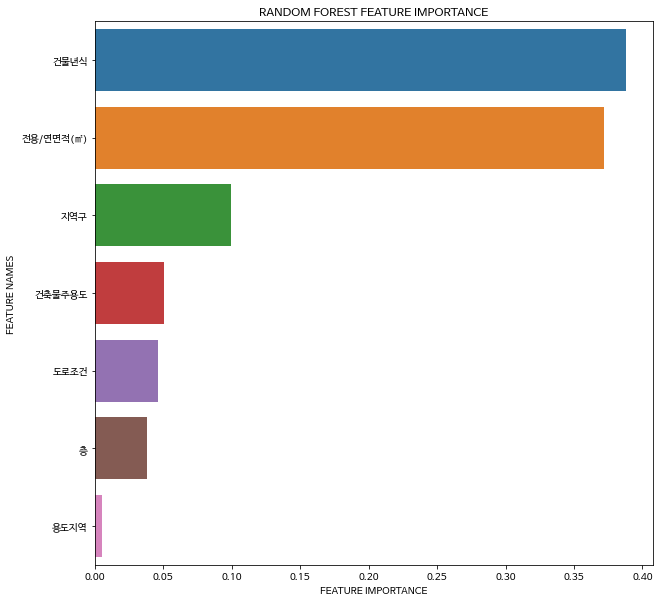

In [ ]:
def plot_feature_importance(importance_, features_,model_type):
      dict_ = {'feature importance' : importance_, 'features' : features_}
      df = pd.DataFrame(dict_)
      df.sort_values(by=['feature importance'], ascending=False,inplace=True)
      plt.figure(figsize=(10,10))
      sns.barplot(x=df['feature importance'], y=df['features'])
      plt.title(model_type + 'FEATURE IMPORTANCE')
      plt.xlabel('FEATURE IMPORTANCE')
      plt.ylabel('FEATURE NAMES')

      
plot_feature_importance(best_rf.feature_importances_, X_val.columns, 'RANDOM FOREST ')

$\color{lightgreen}{\text{Question}}$ : 랜덤 포레스트의 Feature importance에 대해서 설명하고 위의 결과에 대해서 분석하여 Markdown에 기술하세요.
 
$\color{lightgreen}{\text{Answer}}$ : Feature importance는 불순도를 낮추는 정도를 나타내는 지표이다. scikit learn에서의 feature importance는 Gini 중요도를 기반으로 중요도를 측정한다. 하지만, high-cardinality 변수에 대해 overestimate하는 경향이 있다. 그래서 연속형 변수인 '전용/연면적'과 '건물년식'의 경우 importance가 높게 측정된 것으로 보인다. 나머지 변수는 feature engineering 과정에서 낮은 차원으로 변환하였기에 비교적 imporatance가 낮게 측정된 것으로 보인다.
이런 경우에는 permutation feature importance와 같은 방법을 혼합하여 사용하면 개선된다.


###$\color{blue}{\text{3.3. AdaBoost}}$

팀원 간 토론 및 서치를 통해 sklearn 내 AdaBoost 모형을 이해하고 구현. 
Hyperparameter optimization은 반드시 필요하며 각 코드 별로 주석을 달아 구현 사유를 함께 서술!

In [ ]:
#################################################################################
# TODO: Random Forest와 동일한 데이터에 대해 AdaBoost 구현!
#################################################################################
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product

best_ab = None # store the best model into this 
best_mse_ab = 1e10
best_mae_ab = 1e10
best_hyperparameter_ab = None
results_ab = {}

#max_depth, n_estimator, learning_rate 3가지 하이퍼파라미터 튜닝
#learning_rate : boosting과정에서 부여되는 가중치
max_deps = [10, 13, 16, 19, 22, 25] 
n_estimators_ab = [50, 100, 150]
learning_rate = [1, 1.25, 1.5]

#하이퍼파라미터 셋을 카테시안 곱으로 리스트화 하여 저장 후 iteration
params = list(product(max_deps, n_estimators_ab, learning_rate))

for par in params:
  cur_ab = AdaBoostRegressor( DecisionTreeRegressor(max_depth = par[0]), n_estimators = par[1], learning_rate = par[2], loss = 'linear')
  cur_ab.fit(X_train_norm, y_train)
  cur_predicted = cur_ab.predict(X_val_norm)
  cur_mse = mean_squared_error(y_val, cur_predicted)
  cur_mae = mean_absolute_error(y_val, cur_predicted)

  #이전과 동일한 방식으로 MSE기준으로 모델 갱신
  if cur_mse <= best_mse_ab:
    best_ab = cur_ab
    best_mse_ab = cur_mse
    best_mae_ab = cur_mae
    best_hyperparameter_ab = {'max_depth': par[0], 'n_estimators': par[1], 'learning_rate': par[2]}
    print("Updated! \ncurrent model: ", best_ab,
          "\ncurrent MSE: ", cur_mse,
          "\ncurrent MAE: ", cur_mae)

Updated! 
current model:  AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                  learning_rate=1) 
current MSE:  666814.9220947715 
current MAE:  602.6312389408494
Updated! 
current model:  AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=13),
                  learning_rate=1) 
current MSE:  255021.0838046785 
current MAE:  336.0251705256989
Updated! 
current model:  AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=13),
                  learning_rate=1.25) 
current MSE:  247985.9018144872 
current MAE:  334.12800339547573
Updated! 
current model:  AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=16),
                  learning_rate=1) 
current MSE:  162891.71165565305 
current MAE:  232.2927459209894
Updated! 
current model:  AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=19),
                  learning_rate=1) 
current MSE:  117765.56827840696 
current MAE:  156.9779756542545
Updated! 
current model:  AdaBoost

In [ ]:
##Adaboost validation added for training set
print('Validation MSE(㎡당 가격): ', np.mean(np.square(best_ab.predict(X_val_norm) - y_val)))
print('Validation MAE(㎡당 가격):', np.mean(np.abs(best_ab.predict(X_val_norm) - y_val)))

_price = X_val.loc[:, '전용/연면적(㎡)'] * best_ab.predict(X_val_norm)

print('Validation MSE(거래 금액): ', np.mean(np.square(_price - y_val)))
print('Validation MAE(거래 금액): ', np.mean(np.abs(_price - y_val)))
print('Best parameters : ', best_hyperparameter_ab)

Validation MSE(㎡당 가격):  84712.71119227193
Validation MAE(㎡당 가격): 101.57135056746948
Validation MSE(거래 금액):  1478880670392.9236
Validation MAE(거래 금액):  176776.93359691257
Best parameters :  {'max_depth': 25, 'n_estimators': 50, 'learning_rate': 1}


###$\color{blue}{\text{3.4. Implementation for Real-World Practice}}$

새로운 데이터가 들어왔을 때, 지금까지 구현 된 과정을 자동으로 거쳐 새로운 input으로서 모델에 입력하고 산출물을 받을 수 있도록 구현 (test-set 개념으로 진행) ** Random Forest와 AdaBoost 두 모형 모두 활용

In [ ]:
testy = df_test.loc[:, '거래금액(만원)']
y_real = []
for i in np.array(df_test.loc[:, '거래금액(만원)']) :
    y_real.append(float(i.replace(',', '')))
df_test = df_test.drop('거래금액(만원)', 1)
y_price = y_real / df_test.loc[:, '전용/연면적(㎡)']

In [ ]:
import datetime
import math

# 하기의 새로운 df를 Part 1.1 내 df로 간주하고 진행할 것.
df = df_test.copy()

#################################################################################
# TODO: Test set 동일한 처리과정 만들기                                         #
#                                                                               
# Part 1.1에서 만든 방법론을 적용 (Null은 없다고 가정 - 이미 처리했음)
# 1. 데이터 타입처리 (계약년월, 건축년도)
# 2. 지역구 단위의 행정구역 새로운 변수 생성 (변수명 '지역구')
# 3. 건물 년식 일 단위로 하여 새로운 변수 생성 (변수명 '건물년식') 
# 4. 평당가격 변수 추가 
# 5. 과제 1에서 만든 새로운 파생 변수 생성  
#################################################################################
#1
contract_date = []
for i,j in np.array(df[['계약년월', '계약일']]):
  contract_date.append(datetime.datetime(int(str(i)[:4]), int(str(i)[4:6]), int(j)))

df.loc[:, '계약날짜'] = contract_date

construct_yr = []

for i in np.array(df['건축년도']):
  construct_yr.append(datetime.datetime(int(i), 1, 1))

df['건축년도'] = construct_yr

#2
address_type = []

for i in np.array(df['시군구']):
  idx1 = i.find('서울특별시')

  if i.find('구로구') >= 0:
    idx2 = i.find('구로구')
    address_type.append(i[idx1 + 5 : idx2 + 3].strip())
  else:
    idx2 = i.find('구')
    address_type.append(i[idx1 + 5 : idx2 + 1].strip())

df.loc[:, '지역구'] = address_type


#3
df.loc[:, '건물년식'] = df.apply(lambda x : (x['계약날짜'] - x['건축년도']).days, axis=1)


#4
df.loc[:, '평당가격'] = 0.0


#5
##ex.
##지역구 열을 통해 종합주택가격지수라는 새로운 변수를 만들어 볼것임.(해당 지역 건물의 가격을 100으로 기준잡고 등락을 숫자로 보여주는 것)
##출처 : https://data.seoul.go.kr/dataList/801/S/2/datasetView.do 

Price_idx = {'종로구':100.2,'중구':96.9,'용산구':101.4,'성동구':99.0,'광진구':100.0,'동대문구':97.7,
      '중랑구':98.8,'성북구':96.5,'강북구':98.8,'도봉구':96.0,'노원구':93.8,'은평구':98.3,
      '서대문구':97.4,'마포구':98.8,'양천구':99.1,'강서구':98.6,'구로구':99.0,'금천구':98.5,
      '영등포구':98.1,'동작구':100.2,'관악구':98.7,'서초구':103.1,'강남구':101.2,'송파구':98.8,'강동구':99.0}
df.loc[:, '매매가격지수'] = df['지역구'].apply(lambda x : Price_idx[x])

In [ ]:
#################################################################################
# TODO: One hot encoding의 컬럼수 조정                                          #
#                                                                               #
# 1. training set과 test set의 범주형 변수의 종류가 달라질 수 있으므로 이를 train  
#  set의 컬럼으로 통일 (index.isin() 활용)                                         
#################################################################################

#해당 test set에 대한 encoding 부터 진행 >> feature importance 분석으로 인해 encoding 방식을 바꾸어서 진행함.
CATEGORICAL = ['용도지역', '건축물주용도', '도로조건', '지역구'] ##training set에 있던 범주형 변수들

def usage_check(val):
  if val.find('주거') >= 0 or val.find('상업') >= 0:
    return 1
  return 0


for i in CATEGORICAL:
  if i in df.columns:
    if i == '용도지역': #용도지역 encoding
      df.loc[:, '용도지역'] = df['용도지역'].apply(usage_check)

    elif i == '건축물주용도': #건축물주용도 encoding
      #feature engineering에서 median을 통해 구한 encoding rule
      const_usage_dict = {'교육연구': 0, '기타': 1, '제2종근린생활': 2, '판매': 3, '업무': 4, '제1종근린생활': 5, '숙박': 6}

      df.loc[:, '건축물주용도'] = df['건축물주용도'].apply(lambda x : const_usage_dict[x])

    elif i == '도로조건': #도로조건 encoding
      road_con = {'25m미만' : 0, '12m미만' : 1, '8m미만' : 2, '25m이상' : 3}
      df.loc[:, '도로조건'] = df['도로조건'].apply(lambda x : (road_con[x]))

    else: #지역구 encoding

      #feature engineering에서 mean을 통한 군집화를 통해 정한 encoding rule
      loc_number = {'강남구' : 3, '강동구' : 2, '강북구' : 0, '강서구' : 1, '관악구' : 0, '광진구' : 2, '구로구' : 0, '금천구' : 0, '노원구' : 1,
              '도봉구' : 0, '동대문구' : 0, '동작구' : 1, '마포구' : 2, '서대문구' : 2, '서초구' : 3, '성동구' : 2, '성북구' : 0, '송파구' : 3,
              '양천구' : 1, '영등포구' : 1, '용산구' : 3, '은평구' : 1, '종로구' : 3, '중구' : 3, '중랑구' : 0}

      df.loc[:, '지역구'] = df['지역구'].apply(lambda x : (loc_number[x]))

##encoding이 모두 끝나면 필요없는 열들을 모두 제외해서 training set과 맞추기

need_col = ['전용/연면적(㎡)', '층', '건물년식', '평당가격', '거래금액(만원)_adj', '용도지역', '건축물주용도', '도로조건', '지역구']

for i in df.columns:
  if i not in need_col:
    df.drop(i, axis = 1, inplace = True)

#training set과 column 순서 맞추기    
df = df[X_train.columns.to_list()]


In [ ]:
#################################################################################
# TODO: Normalize : training set을 기준으로 진행                                #
#                                                                               #
# 1. training set의 cache를 활용하여 test set normalize    
# ---- z_normalize_val(____, cache)                           
#################################################################################
X_test = df.copy()
X_test_norm = X_test.copy()
X_test_norm.loc[:, ['전용/연면적(㎡)','층','건물년식']] = z_normalize_val(X_test, ['전용/연면적(㎡)','층','건물년식'], cache)


In [ ]:
# Print your test 거래금액 Mean Absolute Error: this should be below 11,000

print('Validation MSE(㎡당 가격): ', np.mean(np.square(best_rf.predict(X_test_norm) - y_price)))
print('Validation MAE(㎡당 가격):', np.mean(np.abs(best_rf.predict(X_test_norm) - y_price)))

_price = X_test.loc[:, '전용/연면적(㎡)'] * best_rf.predict(X_test_norm)

print('Validation MSE(거래 금액): ', np.mean(np.square(_price - y_real)))
print('Validation MAE(거래 금액): ', np.mean(np.abs(_price - y_real)))

In [ ]:
##Adaboost implementation added for test set

# Print your test 거래금액 Mean Absolute Error: this should be below 11,000

print('Validation MSE(㎡당 가격): ', np.mean(np.square(best_ab.predict(X_test_norm) - y_price)))
print('Validation MAE(㎡당 가격):', np.mean(np.abs(best_ab.predict(X_test_norm) - y_price)))

_price = X_test.loc[:, '전용/연면적(㎡)'] * best_ab.predict(X_test_norm)

print('Validation MSE(거래 금액): ', np.mean(np.square(_price - y_real)))
print('Validation MAE(거래 금액): ', np.mean(np.abs(_price - y_real)))